# Satellite Image Processing - Spectral Indices

## Normalized Difference Vegetation Index (NDVI)

A **vegetation index** is the result of a calculation of **spectral** data from different bands composing an optical satellite image (or for example, from a drone, UAV, airborne). Among **vegetation indices**, the **Normalized Difference Vegetation Index (NDVI)** is the most popular.

The **NDVI** is important in the study of vegetation and measures the healthiness ("greenness"), characterization, and density of vegetation in an area.
The **NDVI calculation** is made from the **difference** between the reflectances of the **near infrared** and **visible red** bands divided by the **sum** of the reflectances of these same two bands. The **NDVI equation** is presented below: 

![NDVI_equation.JPG](data\NDVI_equation.JPG)

The result varies from **-1 to 1**, so that the **closer to 1**, the **greater** the **presence of vegetation** (or **healthier vegetation**), and the **closer to -1**, the **greater** the **presence of bare soils and rocks** (or **unhealthy vegetation**).

In the red range, chlorophyll absorbs solar energy causing a low reflectance, while in the near infrared range, both the internal morphology of the leaves and the vegetation structure cause a high reflectance of incident solar energy, resulting in  high values of the satellite image on the infrared channel. For more detailed explanation on this topic, please check this article from [NASA](https://earthobservatory.nasa.gov/features/MeasuringVegetation/measuring_vegetation_2.php).

---

## NDVI Calculation using Sentinel-2 imagery

Now that we have a bit of a background regarding **NDVI**, let's calculate our own **NDVI scene**. We will use the same set of images we used in the previous notebook, covering the province of Utrecht, in the Netherlands.

Let's load the necessary libraries for this task.

In [1]:
# importing necessary libraries
import os

os.environ['PROJ_LIB'] = 'C:\\Users\\JoseCirillo\\anaconda3\\envs\\my_env\\Library\\share\\proj'
import geopandas

import rasterio
from rasterio import plot
import numpy as np
import matplotlib.pyplot as plt

### Accessing the images and creating a composite

Let's use the path directory where all bands we need are located:

In [2]:
# Getting path directory
imagePath = "./data/"

We are going to load each band using the rasterio library. For now, we are taking **bands 2**, **3**, **4** and **8**.

**Important remark - Sentinel-2 satellite imagery have RGB bands corresponding to:<br>
Band 4 - Red<br>
Band 3 - Green<br>
Band 2 - Blue<br>
Band 8 - Nir (Near-infrared)**

In [3]:
# Using path directory to load each band
band2_uft = rasterio.open(imagePath+'T31UFT_20200420T105031_B02_10m.jp2', driver='JP2OpenJPEG') #blue
band3_uft = rasterio.open(imagePath+'T31UFT_20200420T105031_B03_10m.jp2', driver='JP2OpenJPEG') #green
band4_uft = rasterio.open(imagePath+'T31UFT_20200420T105031_B04_10m.jp2', driver='JP2OpenJPEG') #red
band8_uft = rasterio.open(imagePath+'T31UFT_20200420T105031_B08_10m.jp2', driver='JP2OpenJPEG') #nir

### Reading Sentinel-2 image bands and writing the composite

Parsing the bands can be done with ***rasterio*** library. In the previous notebook we parsed 3 bands, but now we are also using **band 8**, **near-infrared**, so the `count` parameter must be updated.

In [4]:
#creating a new tiff composite
composite_uft = rasterio.open(imagePath+'S2A_MSIL2A_20200420T105031_N0214_R051_T31UFT_4bands.tiff','w',driver='GTiff',
                         width=band4_uft.width, height=band4_uft.height,
                         count=4,
                         crs="+proj=utm +zone=31 +ellps=WGS84 +units=m +no_defs ",
                         transform=band4_uft.transform,
                         dtype=band4_uft.dtypes[0]
                         )
# parsing bands RGB
composite_uft.write(band4_uft.read(1),1) #red
composite_uft.write(band3_uft.read(1),2) #green
composite_uft.write(band2_uft.read(1),3) #blue
composite_uft.write(band8_uft.read(1),4) #nir
composite_uft.close()

---

## Geopandas

Once again, let's use ***geopandas*** to read the **province of Utrecht shapefile**, and later on, use it to clip our raster dataset.

In [5]:
# reading shapefile
utrecht_shp = geopandas.read_file(imagePath+'utrecht.shp')

(111377.7283, 174369.6397, 427435.5418499999, 482071.75314999995)

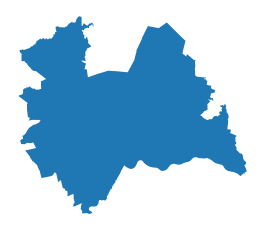

In [6]:
# plotting the province of Utrecht
utrecht_shp.plot()
plt.axis('off')

---

## Clipping Raster

We need to clip our raster dataset, so we can further calculate the **NDVI spectral index** only for our area of interest.

In [7]:
# importing necessary libraries
import rioxarray as rxr
from shapely.geometry import mapping

In [8]:
# opening the dataset with rioxarray
composite_nl = rxr.open_rasterio(imagePath+'S2A_MSIL2A_20200420T105031_N0214_R051_T31UFT_4bands.tiff',masked=True).squeeze()

Here we clip the raster, but first, we have to transform the **coordinate reference system** of the **shapefile** to the **CRS** of the **raster**.

In [9]:
# clipping raster data with polygon shapefile
clipped_composite_nl = composite_nl.rio.clip(utrecht_shp.geometry.apply(mapping),
                                      # applying the intended CRS to the raster data
                                      utrecht_shp.crs)

In [10]:
# writing clipped raster data to disk
clipped_composite_nl.rio.to_raster(imagePath+'clipped_S2A_MSIL2A_20200420T105031_N0214_R051_T31UFT_4bands.tiff')

---

## NDVI calculation

Let's calculate the **NDVI** for the Province of Utrecht from our image example from the date of 20-04-2020.

We will have to open our tiff file and **parse** its **bands** to ***numpy*** arrays again. The difference now is that we will need only bands **red** and **nir**, so let's take **band 1** and **band 4** from our clipped composite.

In [11]:
# opening the dataset with rasterio
utrecht_tiff = rasterio.open(imagePath+'clipped_S2A_MSIL2A_20200420T105031_N0214_R051_T31UFT_4bands.tiff',driver='Gtiff')

# reading bands Red and NIR into numpy arrays
band_red = utrecht_tiff.read(1)
band_nir = utrecht_tiff.read(4)

Let's calculate the **NDVI** considering the equation previously explanined , with **NIR** and **Red** bands as input. In order to avoid errors in **divisions by zero**, we can use `np.seterr` function to handle floating points and ignore this situation.

In [12]:
# allowing division by zero
np.seterr(divide='ignore', invalid='ignore')

# Calculating NDVI
ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)

### NDVI calculation results

We can print the values from our **NDVI calculation**, just to check if we have our expected range of values, from **-1 to 1**.

In [13]:
# quick check on calculated NDVI values
print(np.nanmin(ndvi)) 
print(np.nanmax(ndvi))

-1.0
1.0


### Writing/Saving NDVI image

As the results match our expectations, we can save/write this new product to disk. First, we need to add the **metadata** of our input tiff, in this case **utrecht_tiff**, to the new **NDVI image**. Secondly, we also need to know and add the same `dtype` of the ***numpy array*** we created in the **NDVI calculation** (in this case we have the same `dtype`).

In [14]:
# getting the metadata of the input tiff
meta = utrecht_tiff.meta
print(meta)

# retrieving the dtype from our NDVI
ndvi_dtype = ndvi.dtype
print(ndvi_dtype)


{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 5797, 'height': 4955, 'count': 4, 'crs': CRS.from_epsg(32631), 'transform': Affine(10.0, 0.0, 622570.0,
       0.0, -10.0, 5796720.0)}
float64


When writing our **NDVI** image to disk using ***rasterio*** we will have to specify these **metadata**, in other words, set them as `kwargs` argument. So, we can create a variable named `kwargs` using the **meta** information we need. In addition, we also need to update the `count` value since our **NDVI image** is a **1-band image**.

In [15]:
# creating kwargs variable from meta
kwargs = meta

# updating the count value
kwargs.update(count=1)

Finally, we can write our new raster **NDVI** with the ***rasterio*** library.

In [16]:
# saving new raster file
with rasterio.open(imagePath+'clipped_S2A_MSIL2A_20200420T105031_N0214_R051_T31UFT_NDVI.tiff', 'w', **kwargs) as dst:
        dst.write(ndvi, 1)

---

### Displaying the NDVI image

We can plot now our **NDVI** result of the ***Utrecht province*** for the date ***20-04-2020***.

We are using ***matplotlib*** to visualize the image, and we are able to add extra information such as **title**.

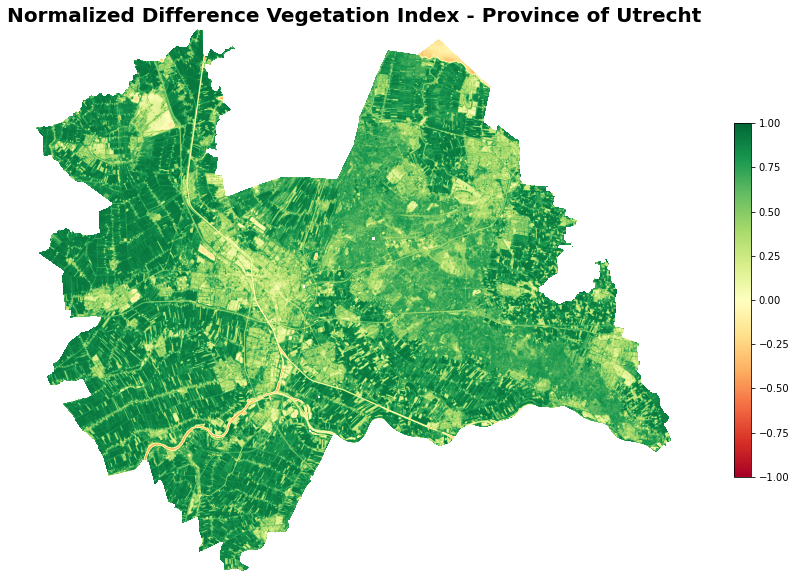

In [17]:
plt.figure(figsize=(22,10))
fig = plt.imshow(ndvi, cmap='RdYlGn',)
plt.colorbar(shrink=0.65)
plt.title('Normalized Difference Vegetation Index - Province of Utrecht', loc='center',fontsize=20, fontweight='bold')
plt.axis('off')
# Displaying the results.
plt.show()